## Assessing the predictability of proteins based on protein-protein reproducibility

**Input:** 
<ul>
    <li> Aggregated protein reproducibility rank</li>
    <li> Prediction scores of the best performing model in NCI CPTAC DREAM Proteomic SubChallenge</ul>
</ul>          

#### Import Packages

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import common_utils
import customized_plots
import graphing_utils as gu
%matplotlib inline
plt.style.use(['seaborn-white'])

In [2]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DATA_PATH']+'/'+'/'.join(folders) +'/'+ fname)
get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/'+'/'.join(folders) +'/'+ fname)

#### Load data

In [3]:
file_proteomic_replicate_correlations = get_local_data_path(['results'], 'TableS2.xlsx')
file_prediction_scores_breast = get_data_path(['mi_yang_25Sept2020'], 'guan_sc2_breast_cor.txt')
file_prediction_scores_ovarian = get_data_path(['mi_yang_25Sept2020'], 'guan_sc2_ovarian_cor.txt')

In [4]:
replicate_ranks = pd.read_excel(file_proteomic_replicate_correlations, sheet_name='B. Protein reproducibility rank', index_col=0)
replicate_ranks[:2]

,Ovarian Reproducibility Rank,Colon Reproducibility Rank,CCLE Reproducibility Rank,Aggregated Reproducibility Rank
A1BG,0.772775,0.45424,NaN,0.575671
A2M,0.883270,0.39603,0.22406,0.501120


In [5]:
replicates_correlations_ccle = replicate_ranks['CCLE Reproducibility Rank'].copy(deep=True).dropna()
replicates_correlations_ov = replicate_ranks['Ovarian Reproducibility Rank'].copy(deep=True).dropna()
replicates_correlations_colon = replicate_ranks['Colon Reproducibility Rank'].copy(deep=True).dropna()
aggregated_normalized_ranks = replicate_ranks['Aggregated Reproducibility Rank'].copy(deep=True).dropna()
replicate_ranks_subset = replicate_ranks.dropna()

In [6]:
prediction_scores_breast = pd.read_csv(file_prediction_scores_breast, sep='\t', index_col=0, squeeze=True)
prediction_scores_breast.name = 'Breast'
print("Dimensions: ", prediction_scores_breast.shape)
prediction_scores_breast[:2]

Dimensions:  (8649,)


A1BG    0.146701
A2M     0.322806
Name: Breast, dtype: float64

In [7]:
prediction_scores_ovarian = pd.read_csv(file_prediction_scores_ovarian, sep='\t', index_col=0, squeeze=True)
print("Dimensions: ", prediction_scores_ovarian.shape)
prediction_scores_ovarian.name = 'Ovarian'
prediction_scores_ovarian[:2]

Dimensions:  (5220,)


A1BG    0.288660
A2M     0.203595
Name: Ovarian, dtype: float64

In [8]:
import statsmodels.api as sm
def ols_fit(x, y):
    x_subset, y_subset = common_utils.get_matched_index(x, y) 
    est = sm.OLS(y_subset, sm.add_constant(x_subset.astype(float))).fit()
    return est

In [9]:
rsquared_predictions = {}

rsquared_predictions['Breast'] = round(ols_fit(x=aggregated_normalized_ranks, 
                                               y=prediction_scores_breast).rsquared_adj*100, 2)
rsquared_predictions['Ovarian'] = round(ols_fit(x=aggregated_normalized_ranks, 
                                                y=prediction_scores_ovarian).rsquared_adj*100, 2)

C:\Users\swath\Anaconda3\envs\thesis\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [10]:
rsquared_predictions_breast = {}
rsquared_predictions_ovarian = {}
for rank in replicate_ranks_subset.columns:
    rsquared_predictions_breast[rank] = round(ols_fit(x=replicate_ranks_subset[rank], y=prediction_scores_breast).rsquared_adj*100, 2) 
    rsquared_predictions_ovarian[rank] = round(ols_fit(x=replicate_ranks_subset[rank], y=prediction_scores_ovarian).rsquared_adj*100, 2) 
    
proteins_count = {study.name: len(study[study.index.isin(replicate_ranks_subset.index)]) for study in [prediction_scores_breast,
                                                                                                       prediction_scores_ovarian]}
rsquared_prediction_scores = common_utils.dataframe_from_dict(['Breast', 'Ovarian', 'Proteins Count'], 
                                                    rsquared_predictions_breast, rsquared_predictions_ovarian, 
                                                    proteins_count, repeat_factor=len(rsquared_predictions_ovarian), 
                                                              interchange_factor_data=True)

Factor,Data,Aggregated Protein Reproducibility Rank,CCLE Protein Reproducibility Rank,Colon Protein Reproducibility Rank,Ovarian Protein Reproducibility Rank,Proteins Count
0,Breast,25.29,13.83,14.97,12.47,2634
1,Ovarian,26.23,12.20,13.71,17.29,2621


In [11]:
palette = [gu.get_color('light-orange')]
args = [gu.additional_plot_parameters(xlab="Aggregated Protein Reproducibility \nDeciles", palette=palette, 
                                                  ylab="Best performer's prediction\nscore", 
                                                  r2=rsquared_predictions['Breast'], title = 'BrCa (2016)'),
        gu.additional_plot_parameters(xlab="Aggregated Protein Reproducibility \nDeciles", palette=palette, 
                                                  ylab="Best performer's prediction\nscore", 
                                                  r2=rsquared_predictions['Ovarian'], title='Ovarian'), 
        gu.additional_plot_parameters(xlab='R-squared (%)', ylab=None, yaxis_grid=False, xaxis_grid=True,  
                                    palette=[gu.get_color(color) for color in ['orange', 'sky-blue', 
                                                                               'reddish-purple', 'green']], 
                                    anchor_legend_at=(1.65, 1))]

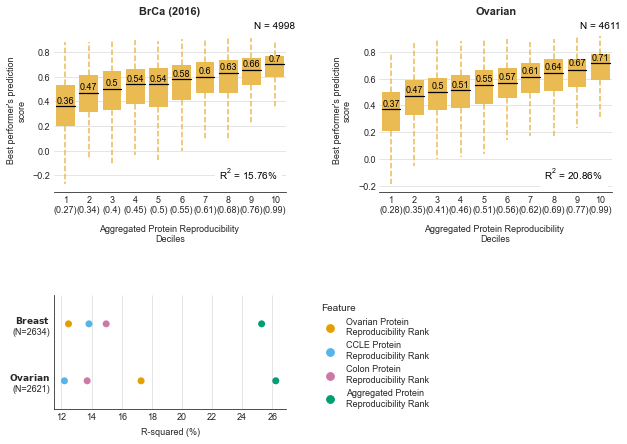

In [12]:
get_order = lambda df: df.groupby(by=['Data']).sum().sort_values('R-squared').index.values
hue_order = ['Ovarian Protein\nReproducibility Rank', 'CCLE Protein\nReproducibility Rank', 
             'Colon Protein\nReproducibility Rank', 'Aggregated Protein\nReproducibility Rank']

with plt.rc_context({'axes.linewidth': 0.8}):
    figure, ax = plt.subplots(2, 2, figsize=(10, 7), gridspec_kw={'height_ratios': [1, 0.7]})
    customized_plots.draw_boxplot(ax[0,0], aggregated_normalized_ranks, prediction_scores_breast, args[0])
    customized_plots.draw_boxplot(ax[0,1], aggregated_normalized_ranks, prediction_scores_ovarian, args[1])
    ax[1,0].spines['left'].set_visible(True)
    customized_plots.draw_dotplot(ax=ax[1, 0], x='R-squared', y='Data', data=rsquared_prediction_scores, hue='Factor', 
                                  order=get_order(rsquared_prediction_scores), args=args[2], hue_order=hue_order)
    ax[1, 1].axis('off')
    plt.subplots_adjust(wspace=0.4, hspace=0.75)
#     figure.savefig('../figures/S4.svg', bbox_inches='tight', dpi=300)

<div class="alert alert-block alert-success">
The predictability of proteins increases with the increase in the deciles of aggregated reproducibility ranks.
</div>